### Get train and test matrices & undersampling

In [1]:
from sklearn.linear_model import LogisticRegression
import shap
import json
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from utilities import configuration
from utilities import health_data

config = configuration.get_config()

experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))

params = experiment_configurations['configuration_1']

# a classic housing price dataset
X_train, y_train, X_test, y_test, columns = health_data.Admission.get_train_test_matrices(params)

model_seed = 1270833263
model_random_state=np.random.RandomState(model_seed)
model = LogisticRegression(max_iter=7000, random_state=model_random_state)


sampling_seed = 1270833263
sampling_random_state=np.random.RandomState(sampling_seed)
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=sampling_random_state)

X, y = under_sampler.fit_resample(X_train, y_train)

model.fit(X,y)


print(X.shape)
print(y.shape)



(34740, 17136)
(34740,)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [2]:
Xnew = X[:,np.var(X.toarray(),axis=0)!=0]
X_test = X_test[:,np.var(X.toarray(),axis=0)!=0]

newcolumns = columns[np.var(X.toarray(),axis=0)!=0]
print(Xnew.shape)
print(newcolumns.shape)

(34740, 8557)
(8557,)


### Feature Selection

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
clf = SelectKBest(f_classif, k=30, ).fit(Xnew, y)
Xnew = clf.transform(Xnew)
X_test = clf.transform(X_test)
# X_test = clf.transform(X_test)
newcolumns = clf.transform(newcolumns.reshape(1,-1))[0,:]

print(len(newcolumns))
for name in newcolumns[:10]:
    print(name)



30
age
alc_days
transfusion given
elective admission
urgent admission
level 1 comorbidity
level 2 comorbidity
Direct Entry
Emergency Entry
New Acute Patient


### SHAP

In [4]:
X_df = pd.DataFrame(Xnew.toarray(), columns=newcolumns)

PermutationExplainer explainer: 34741it [43:07, 13.38it/s]                            


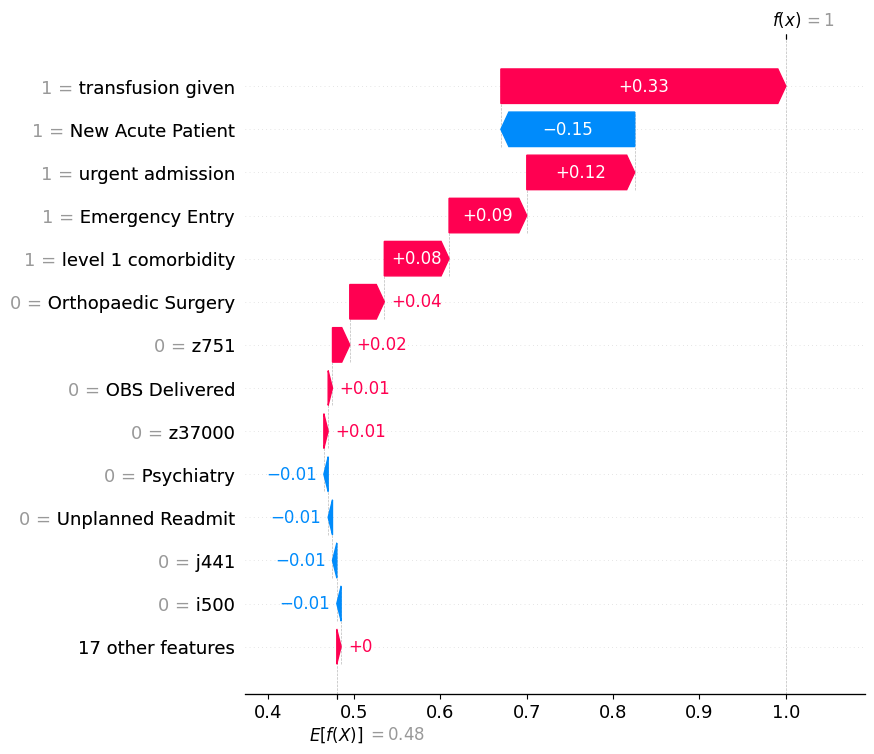

In [5]:
X100 = shap.utils.sample(X_df, 1000)  # 100 instances for use as the background distribution

# a simple linear model
model = LogisticRegression(max_iter=5000)

model.fit(X_df, y)

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X_df, max_evals=2*X_df.shape[1]+1)

sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [70]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


X does not have valid feature names, but LogisticRegression was fitted with feature names


ValueError: X has 17036 features, but LogisticRegression is expecting 30 features as input.

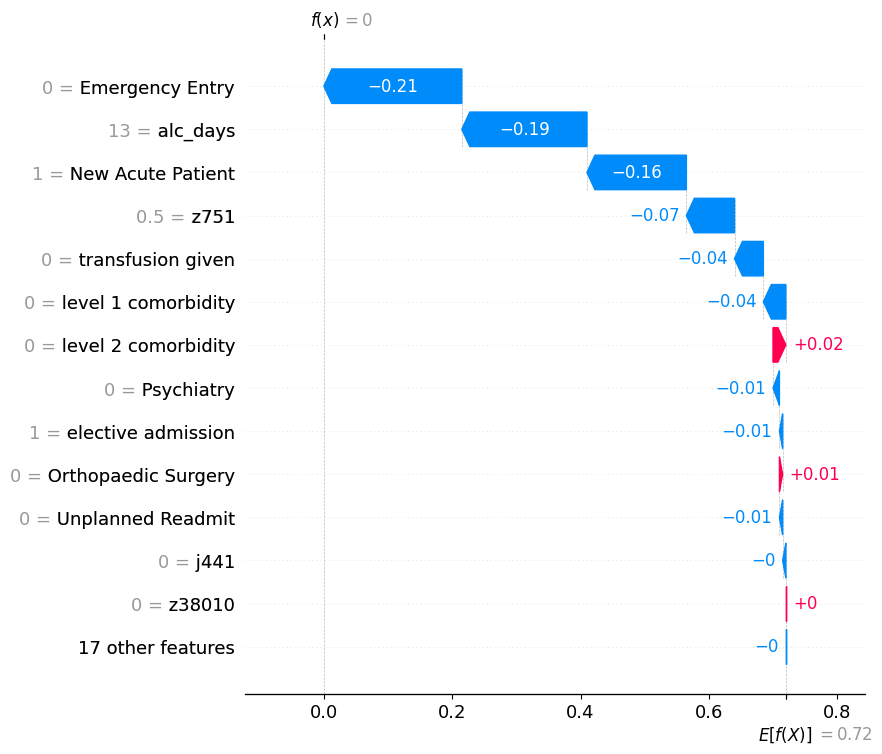

In [32]:
sample_ind = 0
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

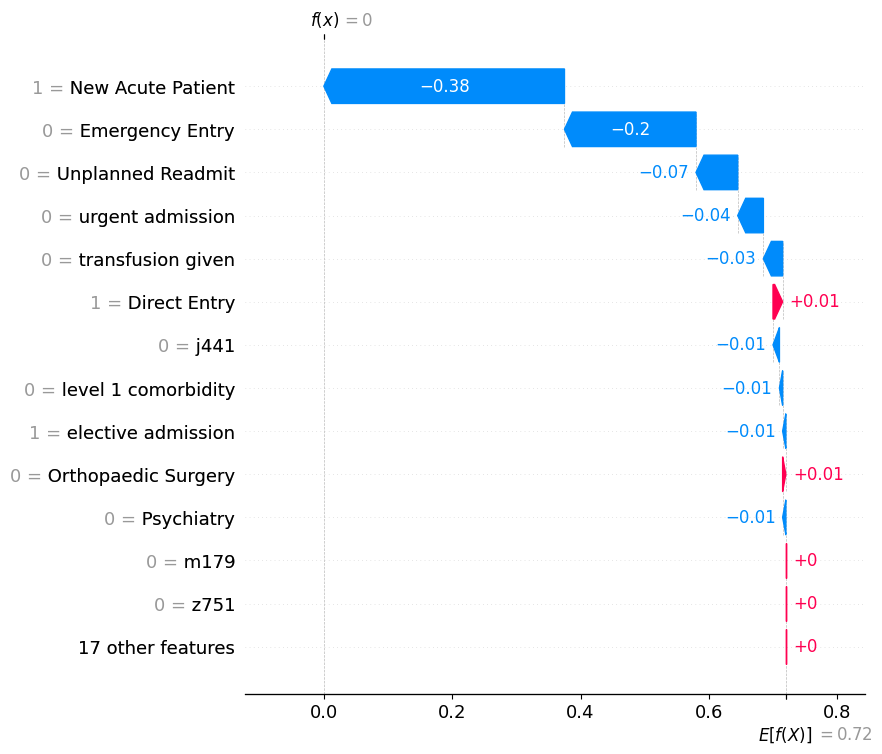

In [33]:
sample_ind = 2
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

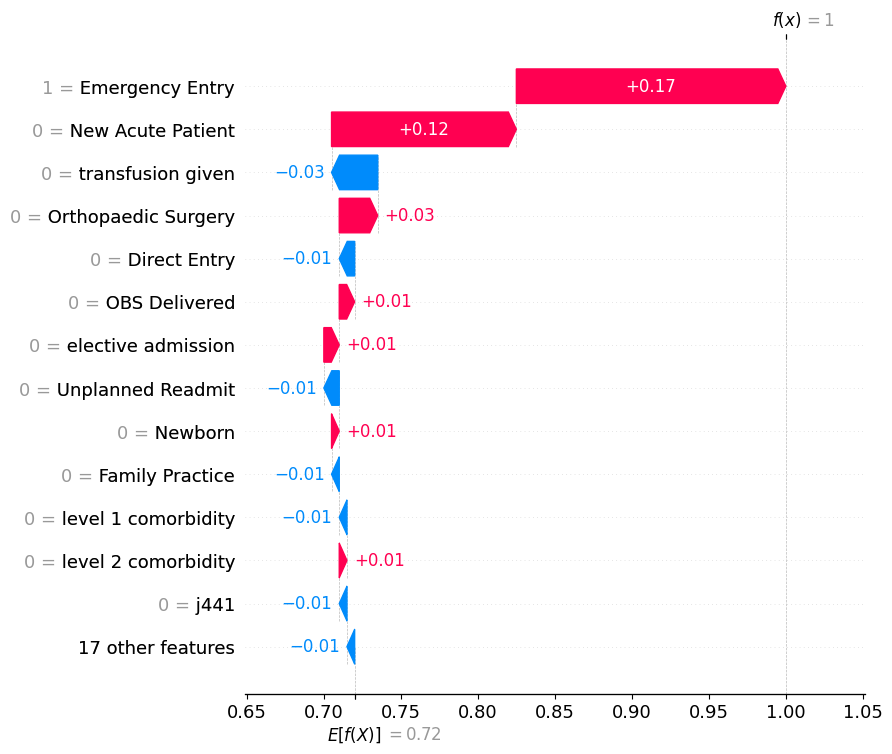

In [34]:
sample_ind = 5
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

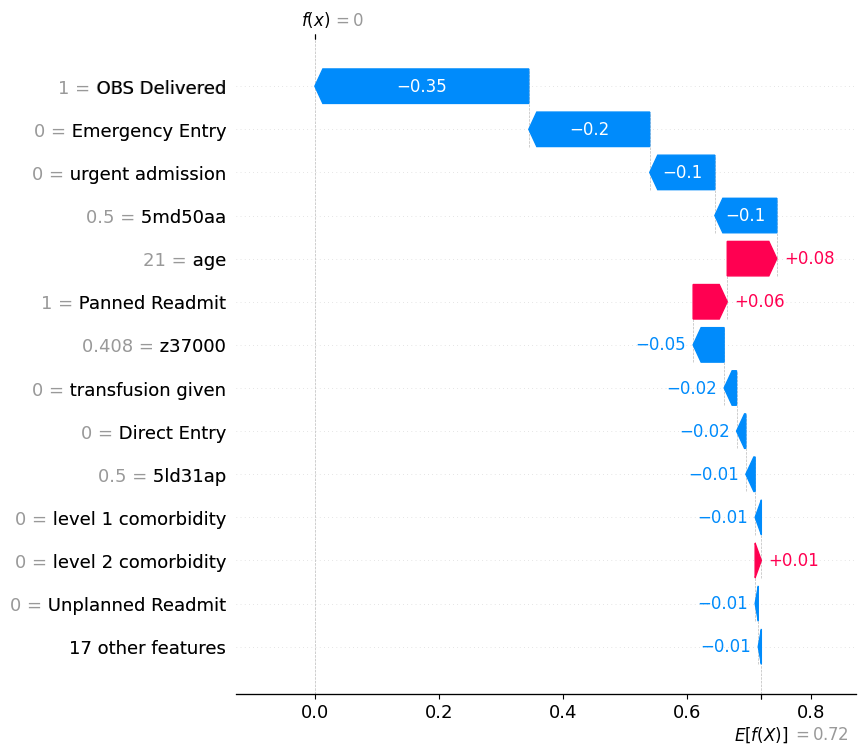

In [36]:
sample_ind = 56
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

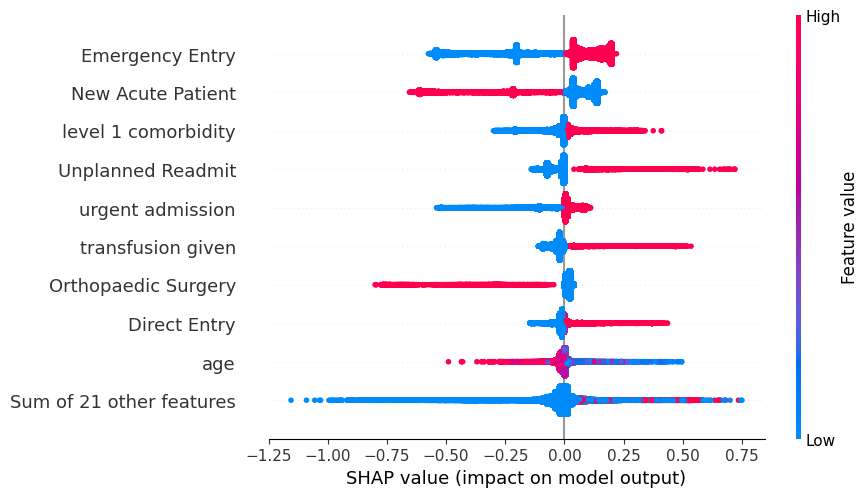

In [56]:
shap.plots.beeswarm(shap_values)

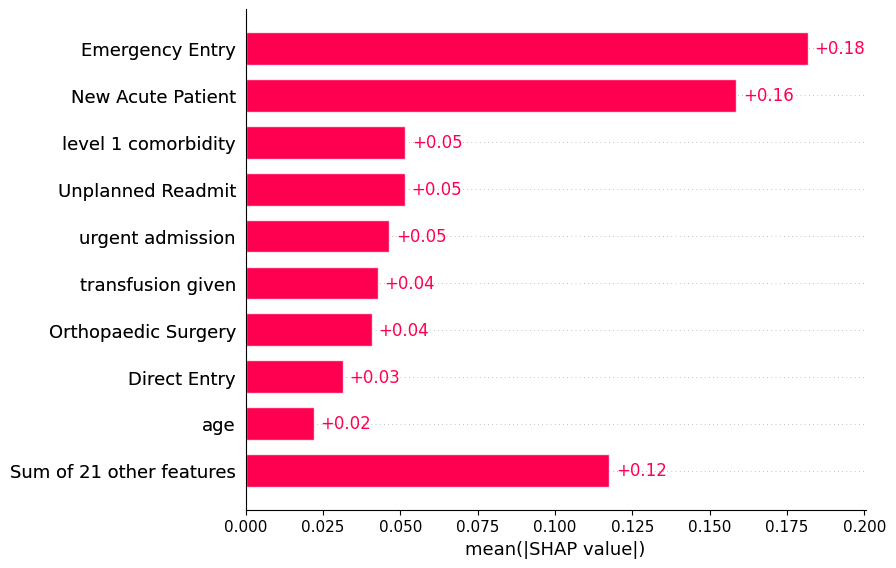

In [57]:
shap.plots.bar(shap_values)


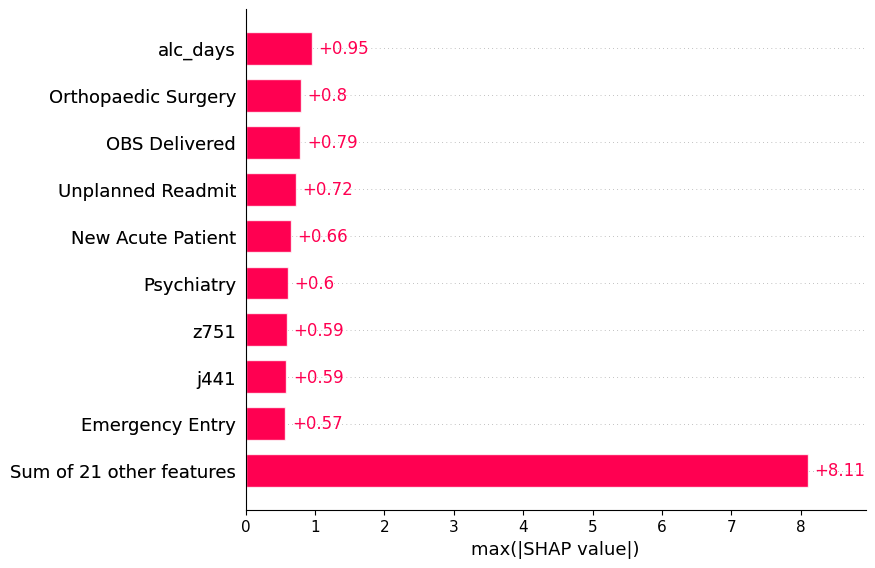

In [58]:
shap.plots.bar(shap_values.abs.max(0))


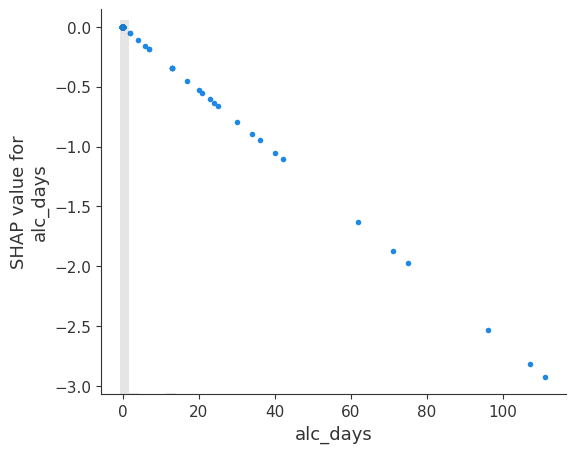

In [66]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_df, max_samples=100)
explainer = shap.Explainer(model, background_adult)
shap_values_adult = explainer(X_df[:1000])
shap.plots.scatter(shap_values_adult[:, "alc_days"])


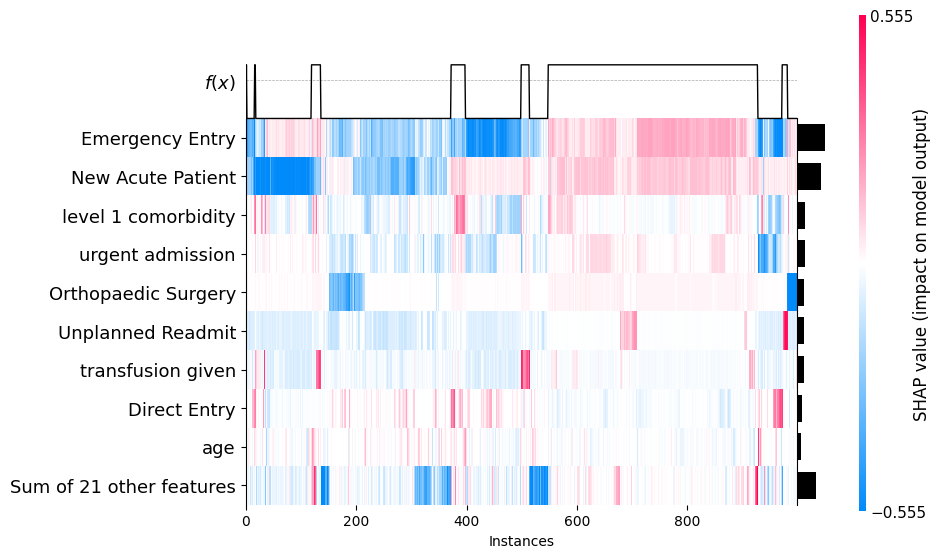

In [67]:
shap.plots.heatmap(shap_values[:1000])
